## MiniLab Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Data preparation: Adjustments](#DataPrep)
    2. [Data preparation for Support Vector Machine](#SVGDataSet)

[Feature Selection](#FeatureSelection)
  * [VIF Feature Removal](#VIF)
  * [Logistic Regression](#LogsticRegression)
    * [Feature Importance](#FI)
	* [Logistic Refit](#Refit)
	* [GridSearch Results](#GridSearch)


In [1]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
 # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve, auc

# others
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions

# custom functions
from cleaning import read_clean_data, impute_data
from tables import classification_report

# set random seed
random_state = 1
np.random.seed(random_state)

Using TensorFlow backend.


In [25]:
X_train = pd.read_csv('X_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')
y_train = pd.read_csv('y_train.txt', header = None).values.flatten()
y_test = pd.read_csv('y_test.txt', header = None).values.flatten()

In [26]:
# It was previously determined to drop these columns based on VIF
drop_cols =  ['BUREAU_CREDIT_ACTIVE_Active',
  'DEBT_CREDIT_RATIO',      
  'PREV_NAME_CONTRACT_TYPE_Cash loans',      
  'PREV_NAME_CONTRACT_TYPE_Consumer loans',     
  'PREV_NAME_CONTRACT_TYPE_Revolving loans',      
  'PREV_NAME_CONTRACT_TYPE_XNA',      
  'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY',      
  'PREV_FLAG_LAST_APPL_PER_CONTRACT_N',      
  'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex',      
  'PREV_NAME_CASH_LOAN_PURPOSE_XAP',      
  'PREV_NAME_CONTRACT_STATUS_Approved',     
  'PREV_NAME_CONTRACT_STATUS_Unused offer',      
  'PREV_NAME_PAYMENT_TYPE_Cash through the bank',      
  'PREV_CODE_REJECT_REASON_CLIENT',      
  'PREV_NAME_CLIENT_TYPE_New',      
  'PREV_NAME_GOODS_CATEGORY_Additional Service',      
  'PREV_NAME_PORTFOLIO_Cards',      
  'PREV_NAME_PORTFOLIO_Cars',      
  'PREV_NAME_PORTFOLIO_Cash',      
  'PREV_NAME_PORTFOLIO_XNA',      
  'PREV_NAME_PRODUCT_TYPE_XNA',      
  'PREV_CHANNEL_TYPE_AP+ (Cash loan)',      
  'PREV_NAME_SELLER_INDUSTRY_Auto technology',      
  'CREDIT_AMT_RECIVABLE',        
  'PREV_NAME_PORTFOLIO_POS',        
  'CREDIT_AMT_TOTAL_RECEIVABLE',        
  'PREV_NAME_CONTRACT_STATUS_Refused',        
  'CREDIT_AMT_RECEIVABLE_PRINCIPAL',        
  'PREV_NAME_YIELD_GROUP_high',        
  'EMPLOYED',        
  'INSTA_DAYS_INSTALMENT',        
  'PREV_NAME_GOODS_CATEGORY_XNA',        
  'PREV_PRODUCT_COMBINATION_POS household with interest',        
  'OBS_60_CNT_SOCIAL_CIRCLE',       
  'PREV_NAME_CASH_LOAN_PURPOSE_XNA',        
  'CREDIT_SK_DPD_DEF',       
  'PREV_NAME_SELLER_INDUSTRY_XNA',       
  'PREV_NFLAG_LAST_APPL_IN_DAY',     
  'CREDIT_AMT_BALANCE',      
  'PREV_CHANNEL_TYPE_Country-wide',   
  'CREDIT_CNT_DRAWINGS_CURRENT',       
  'PREV_AMT_APPLICATION',    
  'PREV_CODE_REJECT_REASON_XAP',  
  'PREV_NAME_PRODUCT_TYPE_x-sell', 
  'PREV_NAME_GOODS_CATEGORY_Mobile', 
  'INSTA_AMT_PAYMENT', 
  'DAYS_EMPLOYED',
  'POS_CNT_INSTALMENT', 
  'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y',
  'AMT_CREDIT', 
  'PREV_AMT_GOODS_PRICE',  
  'CREDIT_AMT_DRAWINGS_CURRENT', 
  'PREV_PRODUCT_COMBINATION_Cash', 
  'CREDIT_INCOME_RATIO', 
  'PREV_PRODUCT_COMBINATION_POS industry with interest', 
  'FLAG_DOCUMENT_3', 
  'PREV_NAME_SELLER_INDUSTRY_Connectivity',
  'REGION_RATING_CLIENT', 
  'PREV_DAYS_TERMINATION',
  'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories',
  'POS_MONTHS_BALANCE',
  'CREDIT_AMT_PAYMENT_TOTAL_CURRENT',
  'REG_REGION_NOT_WORK_REGION',
  'PREV_DAYS_FIRST_DRAWING',
  'CREDIT_NAME_CONTRACT_STATUS_Active',
   'CNT_CHILDREN', 
   'PREV_NAME_SELLER_INDUSTRY_Consumer electronics', 
   'PREV_NAME_YIELD_GROUP_XNA', 
   'PREV_AMT_CREDIT',
   'REG_CITY_NOT_WORK_CITY', 
   'PREV_NAME_PRODUCT_TYPE_walk-in',
   'CREDIT_CNT_INSTALMENT_MATURE_CUM',
   'BUREAU_DAYS_CREDIT',
   'PREV_NAME_GOODS_CATEGORY_Furniture',
   'PREV_DAYS_DECISION'
  ] 

In [27]:
X_train.drop(columns=drop_cols, inplace=True, axis=1)
X_test.drop(columns=drop_cols, inplace=True, axis=1)

In [ ]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0):
        """Iteratively calculate VIF and drop features with highest VIF until
        all VIF values are below the threshold value (`thresh`).
        
        Adapted from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
        """
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

# Feature Selection <a class="anchor" id="FeatureSelection"></a>

Feature selection was performed by removing features with high variance inflation factor (VIF) and ranking features by feature importance  with an ensemble of models (regularized logistic regression).



## VIF Feature Removal <a class="anchor" id="VIF"></a>

High VIF is an [indication of multicollinearity](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html).
Typically, limiting VIF of individual features to 5 is considered reasonable.
For removal by VIF, features with high VIF were removed iteratively until the VIF for all remain features was less than 5.
The removed features are printed by the code below.

In [166]:
transformer = ReduceVIF()
X = transformer.fit_transform(X_train_svm_as_df)

ReduceVIF fit
ReduceVIF transform
Dropping FLAG_EMP_PHONE with vif=inf
Dropping OBS_60_CNT_SOCIAL_CIRCLE with vif=305.3946955343683
Dropping DAYS_EMPLOYED with vif=26.56876041129738
Dropping CREDIT_INCOME_RATIO with vif=12.804099800794145
Dropping FLAG_DOCUMENT_3 with vif=12.364427566035257
Dropping REGION_RATING_CLIENT with vif=11.32963331226173
Dropping REG_REGION_NOT_WORK_REGION with vif=8.868417498179573
Dropping REG_CITY_NOT_WORK_CITY with vif=6.577035347074841


## Logistic Regression <a class="anchor" id="LogsticRegression"></a>

Each type of regularized logistic regression (L1, L2, ElasticNet) was grid search for the bast hyperparameters.
Then the regularized logistic regression models were fit with the hyperparameters selected by [grid search]().
After the fits, features where ranked by the mean absolute importance from the model fits ([see table](#FI)).

**Note**: ElasticNet was not refit because the grid search or elastic net selected 0 for the regularization mixing parameter,
  which is just L1 regularization.

In [50]:
X = X_train

In [59]:
logistic_l1 = LogisticRegression(C = 0.01,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 random_state = random_state)
logistic_l1.fit(X, y_train);

/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [60]:

coefs = logistic_l1.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l1 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l1['Abs Weight'] = np.abs(final_df_logistic_l1['Logistic Weight'])
final_df_logistic_l1.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l1.to_string(index=False))

In [61]:
logistic_l2 = LogisticRegression(C = 0.01, 
                                 penalty = 'l2',
                                 solver = 'lbfgs', 
                                 random_state = random_state)
logistic_l2.fit(X, y_train);

In [62]:
coefs = logistic_l2.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l2 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l2['Abs Weight'] = np.abs(final_df_logistic_l2['Logistic Weight'])
final_df_logistic_l2.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l2.to_string(index=False))

In [63]:
# prevent risk of object corruption
l2 = final_df_logistic_l2.sort_values('Feature').copy().add_suffix('_l2')
l1 = final_df_logistic_l1.sort_values('Feature').copy().add_suffix('_l1')

### Feature Importance <a class="anchor" id="FI"></a>

The importances were combined for each model and ranked by the mean absolute importance (logstic weight).
The weights for each model were also included. 
The difference and percent difference between the weights for each model is also shown.

The difference in feature weight between the two models is not substantial in the first 30 features.
There are only a feature features with substantial differences in weights, such as sign changes.
All of these features have low importances.

In [64]:
combined = pd.concat([l1, l2], keys=['Feature_l1', 'Feature_l2'], axis = 1)
combined['Average Weight'] = (combined['Feature_l1']['Abs Weight_l1'] 
                              + combined['Feature_l2']['Abs Weight_l2']) / 2
average_weights = pd.DataFrame()
average_weights['Mean_Abs_Weight'] = combined['Average Weight']
average_weights['Feature'] = combined['Feature_l1']['Feature_l1']
average_weights['l1_Weight'] = combined['Feature_l1']['Logistic Weight_l1']
average_weights['l2_Weight'] = combined['Feature_l2']['Logistic Weight_l2']
average_weights['Importance_Difference'] = average_weights['l1_Weight'] - average_weights['l2_Weight']
average_weights['Importance_Difference_%'] = (average_weights['Importance_Difference'] 
                                              / average_weights['Mean_Abs_Weight'] 
                                              * 100)
average_weights = average_weights.sort_values('Mean_Abs_Weight', ascending = False).reset_index(drop = True)
average_weights

,Mean_Abs_Weight,Feature,l1_Weight,l2_Weight,Importance_Difference,Importance_Difference_%
0,0.403668,EXT_SOURCE_2,-4.077526e-01,-0.399584,-0.008168,-2.023503
1,0.389945,EXT_SOURCE_3,-3.861163e-01,-0.393774,0.007658,1.963759
2,0.290173,NAME_EDUCATION_TYPE,-9.881313e-02,-0.481534,0.382720,131.893718
3,0.184023,BUREAU_CREDIT_CURRENCY_currency 1,2.161612e-01,0.151884,0.064277,34.929018
4,0.183270,PREV_CNT_PAYMENT,1.698537e-01,0.196687,-0.026833,-14.641367
5,0.158725,CODE_GENDER,-1.508282e-01,-0.166622,0.015794,9.950591
6,0.150261,EXT_SOURCE_1,-1.515846e-01,-0.148937,-0.002648,-1.761957
7,0.147494,PREV_CODE_REJECT_REASON_HC,1.424261e-01,0.152562,-0.010136,-6.872013
8,0.140537,PERCENT_EMPLOYED_TO_AGE,-1.336042e-01,-0.147469,0.013865,9.865714
9,0.137119,POS_CNT_INSTALMENT_FUTURE,1.199824e-01,0.154255,-0.034273,-24.994857


### Refit with Important Features <a class="anchor" id="Refit"></a>

#### Logistic Regression

A logistic classifier was refit using 10 - 250 features in steps of 10 features.
The plot below shows that the performance of logistic regression stabilizes after the 50 most important features were included in the model.

In [98]:
log_acc = list()
log_recall = list()
log_pre = list()
feat_count = list()

l = LogisticRegression(C = 0.01, 
                       penalty = 'l2',
                       solver = 'lbfgs', 
                       random_state = random_state)

for f_count in range(10,260,10):
    feat_count.append(f_count)
    
    l.fit(X_train[average_weights.iloc[0:f_count].Feature],y_train)

    # using it on test set
    y_pred = l.predict(X_test[average_weights.iloc[0:f_count].Feature])
    #results = confusion_matrix(y_test, y_pred)

    log_acc.append(accuracy_score(y_test, y_pred))
    log_pre.append(precision_score(y_test, y_pred))
    log_recall.append(recall_score(y_test, y_pred))

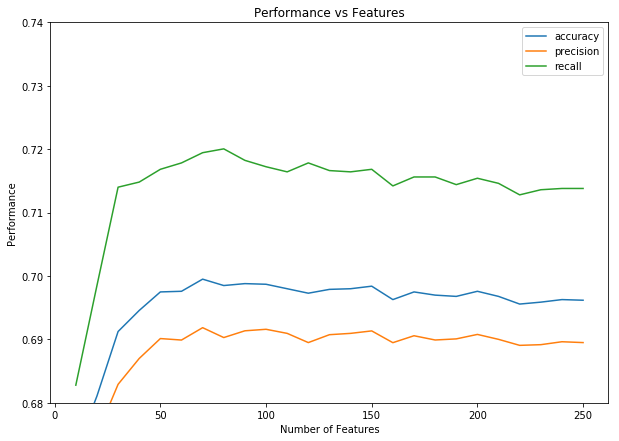

In [107]:
plt.figure(figsize=(10,7))
plt.plot(feat_count, log_acc, label = 'accuracy')
plt.plot(feat_count, log_pre, label = 'precision')
plt.plot(feat_count, log_recall, label = 'recall')
plt.legend()
plt.title('Performance vs Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.ylim((0.68, 0.74))
plt.show();

Fit and test the logistic model on the 50 most important features.

In [100]:
l = LogisticRegression(C = 0.01, 
                       penalty = 'l2',
                       solver = 'lbfgs', 
                       random_state = random_state)
l.fit(X[average_weights.iloc[0:50].Feature],y_train)
#X_test = pd.DataFrame(X_test, columns=downsampled.drop(labels = ['TARGET'], axis = 1).columns)
preds = l.predict(X_test[average_weights.iloc[0:50].Feature])
classification_report(y_test, preds)

Classification Report

Confusion Matrix
Predicted   0.0   1.0   All
True                       
0.0        3367  1598  4965
1.0        1406  3559  4965
All        4773  5157  9930

Accuracy: 69.75% 
Precision: 69.01% 
Recall: 71.68%


**ROC Curve**

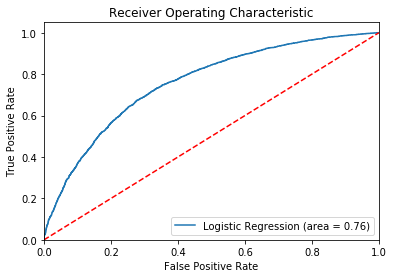

In [101]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, l.predict_proba(X_test[average_weights.iloc[0:50].Feature])[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

#### Hist Gradient Boosting Machine

A HGBM was refit using 10 - 250 features in steps of 10 features.
The plot below shows that the performance of HGMB stabilizes after the 75 most important features were included in the model.

In [83]:
hgbm_acc = list()
hgbm_recall = list()
hgbm_pre = list()
feat_count = list()

clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = random_state)


for f_count in range(10,260,10):
    feat_count.append(f_count)
    
    clf.fit(X_train[average_weights.iloc[0:f_count].Feature],y_train)

    # using it on test set
    y_pred = clf.predict(X_test[average_weights.iloc[0:f_count].Feature])
    #results = confusion_matrix(y_test, y_pred)

    hgbm_acc.append(accuracy_score(y_test, y_pred))
    hgbm_pre.append(precision_score(y_test, y_pred))
    hgbm_recall.append(recall_score(y_test, y_pred))
    
    #classification_report(y_test, y_pred)

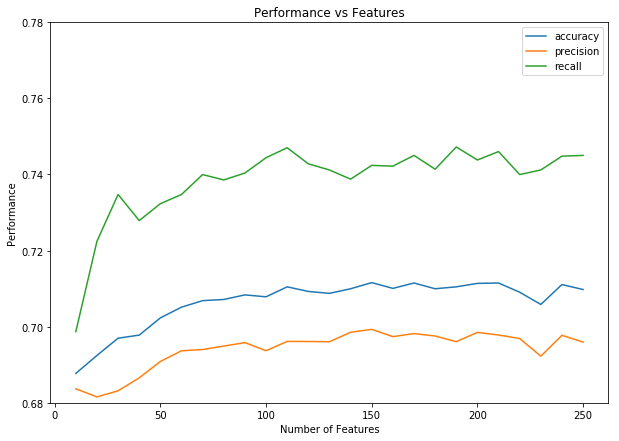

In [97]:
plt.figure(figsize=(10,7))
plt.plot(feat_count, hgbm_acc, label = 'accuracy')
plt.plot(feat_count, hgbm_pre, label = 'precision')
plt.plot(feat_count, hgbm_recall, label = 'recall')
plt.legend()
plt.title('Performance vs Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.ylim((0.68, 0.78))
plt.show();

Fit and test the HGBM model on the 75 most important features.

In [103]:
# prediction with all features
clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = random_state)



clf.fit(X_train[average_weights.iloc[0:75].Feature],y_train)

# using it on test set
y_pred = clf.predict(X_test[average_weights.iloc[0:75].Feature])
results = confusion_matrix(y_test, y_pred)

classification_report(y_test, y_pred)

Classification Report

Confusion Matrix
Predicted   0.0   1.0   All
True                       
0.0        3348  1617  4965
1.0        1264  3701  4965
All        4612  5318  9930

Accuracy: 70.99% 
Precision: 69.59% 
Recall: 74.54%


**ROC Curve**

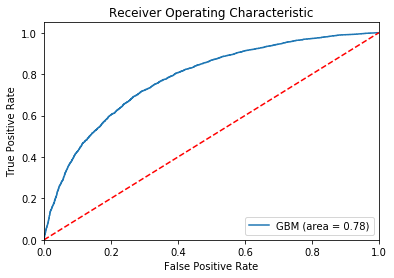

In [106]:

# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test[average_weights.iloc[0:75].Feature])[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'GBM (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression Parameter Grid Search <a class="anchor" id="GridSearch"></a>

Each type of regularized logistic regression was grid search for the best hyperparameters before fitting the model for estimating feature importances.

* L2 Regulaization
* L1 Regulaization
* Elastic Net Regulaization

### L2 Regulaization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ for L2 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [28]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'newton-cg',
                     'lbfgs',
                     'sag',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l2', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
# Fit on data
#best_clf = clf.fit(X_train_svm, y_train_svm)

# Tuning hyper-parameters for precision



/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_ite

KeyboardInterrupt: 

### l1 Regularization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘liblinear’ and ‘saga’ for L1 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [ ]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'liblinear',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l1', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

### Elastic Net

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-4, 4) with 10 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘saga’ for elastic-net
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 10 steps

In [ ]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':['saga'],
        'C':np.logspace(-4, 4, 10),
        'l1_ratio':np.linspace(0, 1, 10)
    }]

model = LogisticRegression(penalty = 'elasticnet', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
